In [ ]:
import numpy as np
import pandas as pd
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os
import tensorflow as tf

In [ ]:
fashionMnist = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
(xTrainFull, yTrainFull), (xTest, yTest) = fashionMnist

In [ ]:
xTrainFull.shape

(60000, 28, 28)

In [ ]:
def flatten_images(images):
    """
    Flatten each image in the dataset from 28x28 to 784.

    Parameters:
    images (numpy.ndarray): Array of images with shape (n_images, 28, 28).

    Returns:
    numpy.ndarray: Array of flattened images with shape (n_images, 784).
    """
    n_images = images.shape[0]
    flattened_images = np.zeros((n_images, 784))

    for i in range(n_images):
        flattened_images[i] = images[i].reshape(-1)  # Reshape 28x28 to 784

    return flattened_images

In [ ]:
xTrain, xTest = flatten_images(xTrainFull), flatten_images(xTest)
xTrain.shape, xTest.shape

((60000, 784), (10000, 784))

In [ ]:
classes = np.unique(yTrainFull)
print(len(classes))

10


In [ ]:
xTrain=np.dstack([xTrain] * 3)
xTest=np.dstack([xTest]*3)
xTrain.shape,xTest.shape

((60000, 784, 3), (10000, 784, 3))

In [ ]:
# Reshape images as per the tensor format required by tensorflow
xTrain = xTrain.reshape(-1, 28,28,3)
xTest= xTest.reshape (-1,28,28,3)
xTrain.shape,xTest.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img
xTrain = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xTrain])
xTest = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xTest])
#xTrain = preprocess_input(x)
xTrain.shape, xTest.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [ ]:
# Normalise the data and change data type
xTrain = xTrain / 255.
xTest = xTest / 255.
xTrain = xTrain.astype('float32')
xTest = xTest.astype('float32')

In [ ]:
train_Y_one_hot = to_categorical(yTrainFull)
test_Y_one_hot = to_categorical(yTest)

In [ ]:
train_Y_one_hot[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
xTrain, xValid, train_label, valid_label = train_test_split(xTrain,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [ ]:
xTrain.shape, xValid.shape, train_label.shape, valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

In [ ]:
train_label[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

In [ ]:
train_X = preprocess_input(xTrain)
valid_X = preprocess_input(xValid)
test_X  = preprocess_input (xTest)

In [ ]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH),
                  pooling="avg",
                  classifier_activation="softmax",
                 )
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [22]:
train_features = conv_base.predict(np.array(xTrain), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(xTest), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(xValid), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 273s 364ms/step


In [25]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, yTest)
np.savez("val_features", val_features, valid_label)

In [24]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 512) 
 (10000, 512) 
 (12000, 512)


In [26]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [28]:
from keras import models
from keras.models import Model
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.layers import LeakyReLU

In [31]:
numClasses = 10

In [32]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(numClasses, activation='softmax'))

In [33]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
  # optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

In [34]:
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [35]:
# Train the Model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=NB_EPOCHS,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/100
1500/1500 [==============================] - 12s 7ms/step - loss: 1.5549 - acc: 0.4270 - val_loss: 1.3271 - val_acc: 0.5058 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 9s 6ms/step - loss: 1.1912 - acc: 0.5545 - val_loss: 1.1439 - val_acc: 0.5583 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 9s 6ms/step - loss: 1.0794 - acc: 0.5972 - val_loss: 1.0024 - val_acc: 0.6486 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 10s 7ms/step - loss: 1.0166 - acc: 0.6231 - val_loss: 1.0729 - val_acc: 0.6097 - lr: 0.0010
Epoch 5/100
1498/1500 [============================>.] - ETA: 0s - loss: 0.9728 - acc: 0.6411
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 10s 7ms/step - loss: 0.9728 - acc: 0.6411 - val_loss: 1.0036 - val_acc: 0.6289 - lr: 0.0010
Epoch 6/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.8802 - acc: 0.6831

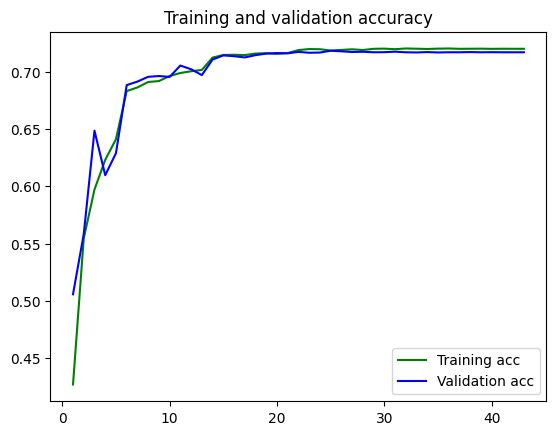

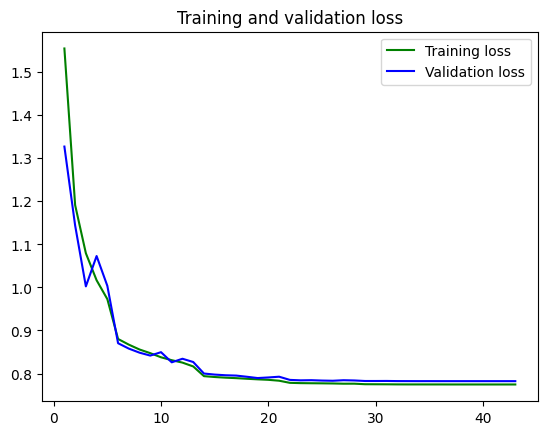

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()